In [1]:
! pip install -q kaggle

In [2]:
from google.colab import drive

# mount your Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
import tensorflow as tf
import os
import cv2
import imghdr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img , img_to_array , ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import InceptionV3, VGG16

from sklearn.metrics import accuracy_score, precision_recall_fscore_support


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from os import listdir
from os.path import isdir, isfile, join
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
os.environ['KAGGLE_USERNAME']='samirabj'

In [5]:
os.environ['KAGGLE_KEY']='1cd09e76ad5bfbf07bb3e249844ef68b'

In [6]:
!kaggle datasets download -d trolukovich/food11-image-dataset

food11-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
#uploading the data

from zipfile import ZipFile

file_name='/content/food11-image-dataset.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("done")

done


In [8]:
TRAIN_DATA_DIR = "/content/training"
TEST_DATA_DIR = "/content/validation"
VAL_DATA_DIR = "/content/evaluation"

In [9]:
CLASSES = sorted(listdir(TRAIN_DATA_DIR))
CLASSES

['Bread',
 'Dairy product',
 'Dessert',
 'Egg',
 'Fried food',
 'Meat',
 'Noodles-Pasta',
 'Rice',
 'Seafood',
 'Soup',
 'Vegetable-Fruit']

In [111]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)

# For test data we only rescale the data.
# Never augment test data!!!
test_datagen = ImageDataGenerator(rescale=1./255)


In [112]:
# Train generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(128, 128),
    batch_size=32,
    classes=CLASSES,
    class_mode='categorical'
)
# Test generator
test_generator = test_datagen.flow_from_directory(
    VAL_DATA_DIR, 
    classes=CLASSES,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 9866 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


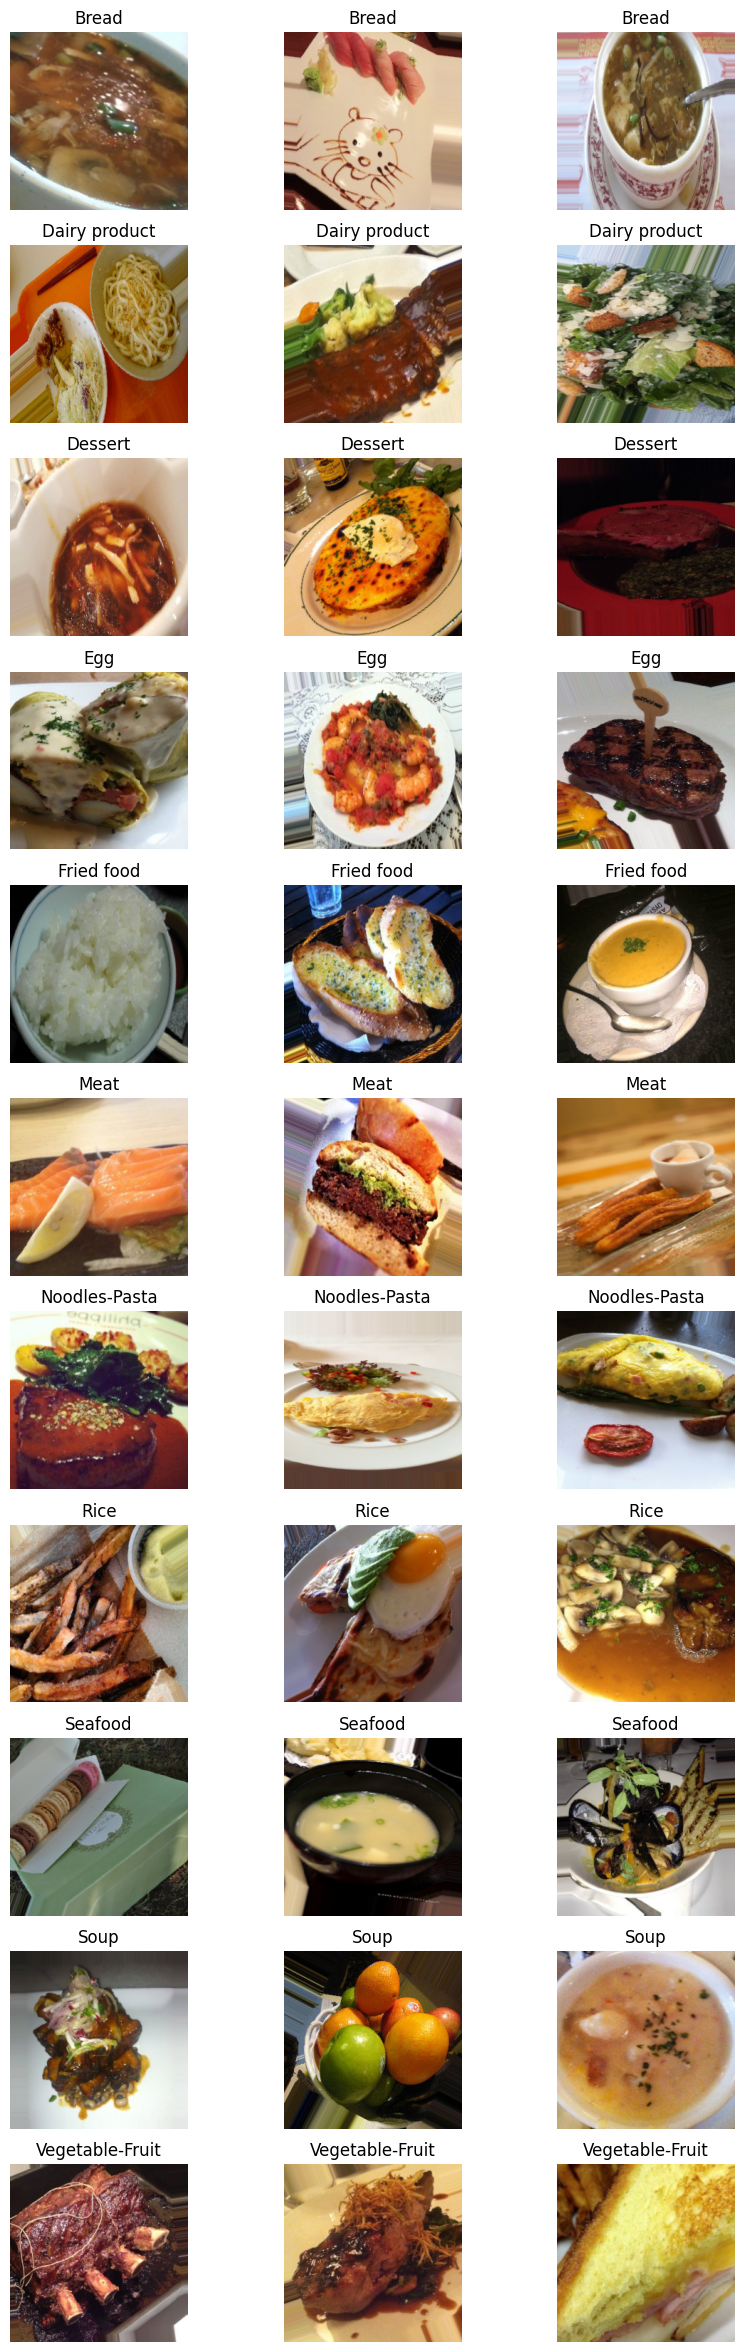

In [157]:
import matplotlib.pyplot as plt

# Get the integer labels for each category
class_indices = train_generator.class_indices

# Create a figure with 33 subplots (11 categories * 3 images each)
fig, axes = plt.subplots(11, 3, figsize=(10, 30))

# Loop through each category
for i, (category, label) in enumerate(class_indices.items()):
    # Loop 3 times to show 3 images of this category
    for j in range(3):
        # Get one image from the generator for this category
        img, _ = train_generator.next()
        img = img[0]  # select the first image from the batch

        # Display the image in the corresponding subplot
        ax = axes[i, j]
        ax.imshow(img)
        ax.set_title(category)
        ax.axis('off')

# Show the plot
plt.show()


In [ ]:
sample_batch = next(train_generator)

sample_batch[0].shape

(32, 128, 128, 3)

### Simple cnn model

In [127]:
model = tf.keras.models.Sequential([

    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=sample_batch[0].shape[1:]),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(11, activation='softmax')

])

In [ ]:
model.compile(optimizer='adam',
                   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                    

In [ ]:
## Early stopping to stop over training
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
BATCH_SIZE=32
history = model.fit(
    train_generator, 
    epochs=50, 
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[early_stop],
    verbose=True
)

Epoch 1/50
308/308 [==============================] - 141s 435ms/step - loss: 2.1711 - accuracy: 0.2230 - val_loss: 1.9283 - val_accuracy: 0.3278
Epoch 2/50
308/308 [==============================] - 110s 357ms/step - loss: 1.9170 - accuracy: 0.3265 - val_loss: 1.7619 - val_accuracy: 0.3939
Epoch 3/50
308/308 [==============================] - 134s 435ms/step - loss: 1.7930 - accuracy: 0.3672 - val_loss: 1.8226 - val_accuracy: 0.3933
Epoch 4/50
308/308 [==============================] - 112s 362ms/step - loss: 1.6842 - accuracy: 0.4063 - val_loss: 1.6004 - val_accuracy: 0.4438
Epoch 5/50
308/308 [==============================] - 110s 356ms/step - loss: 1.5956 - accuracy: 0.4425 - val_loss: 1.7165 - val_accuracy: 0.4198
Epoch 6/50
308/308 [==============================] - 110s 357ms/step - loss: 1.5221 - accuracy: 0.4675 - val_loss: 1.4994 - val_accuracy: 0.4841
Epoch 7/50
308/308 [==============================] - 111s 362ms/step - loss: 1.4437 - accuracy: 0.4921 - val_loss: 1.4891 -

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print("Loss:", loss)
print("Accuracy:", accuracy)

105/105 [==============================] - 21s 202ms/step - loss: 1.3230 - accuracy: 0.5748
Loss: 1.3230289220809937
Accuracy: 0.574843168258667


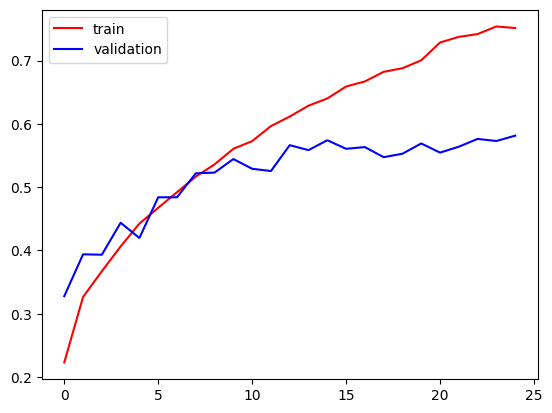

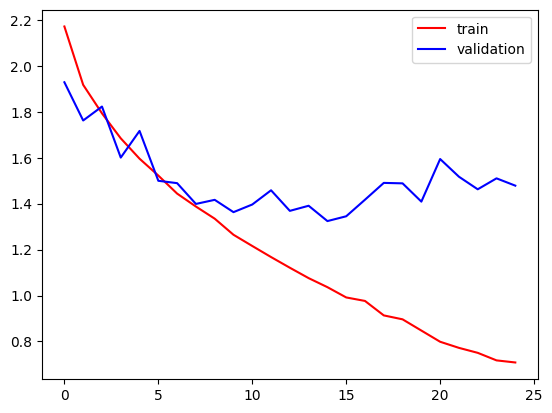

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()
     

In [ ]:
# save the model file to your Google Drive
model.save('/content/gdrive/My Drive/model.h5')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/gdrive/MyDrive/model.h5')

We have a difference between test accuracy and train accuracy so our model is overfitting

To try to fix this problem we can try to add dropout layers

## MODEL WITH DROPOUT

In [ ]:
model_2_with_dropout = tf.keras.models.Sequential([

    layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=sample_batch[0].shape[1:]),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.25),

    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Flatten(),

    tf.keras.layers.Dropout(0.5),

    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(11, activation='softmax')

])

In [ ]:
model_2_with_dropout.compile(optimizer='adam',
                   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

In [ ]:
model_2_with_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 dropout (Dropout)           (None, 64, 64, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 256)       295168    
                                                      

In [ ]:
## Early stopping to stop over training
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, mode='min')
BATCH_SIZE=32
history = model_2_with_dropout.fit(
    train_generator, 
    epochs=50, 
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[early_stop],
    verbose=True
)

Epoch 1/50
308/308 [==============================] - 127s 390ms/step - loss: 2.2280 - accuracy: 0.1978 - val_loss: 2.1251 - val_accuracy: 0.2314
Epoch 2/50
308/308 [==============================] - 115s 374ms/step - loss: 2.0602 - accuracy: 0.2735 - val_loss: 1.9893 - val_accuracy: 0.3047
Epoch 3/50
308/308 [==============================] - 136s 443ms/step - loss: 1.9441 - accuracy: 0.3151 - val_loss: 1.8436 - val_accuracy: 0.3546
Epoch 4/50
308/308 [==============================] - 115s 374ms/step - loss: 1.8732 - accuracy: 0.3426 - val_loss: 1.7729 - val_accuracy: 0.3957
Epoch 5/50
308/308 [==============================] - 137s 443ms/step - loss: 1.8175 - accuracy: 0.3698 - val_loss: 1.7187 - val_accuracy: 0.4123
Epoch 6/50
308/308 [==============================] - 116s 378ms/step - loss: 1.7419 - accuracy: 0.3897 - val_loss: 1.6976 - val_accuracy: 0.4111
Epoch 7/50
308/308 [==============================] - 116s 376ms/step - loss: 1.6842 - accuracy: 0.4154 - val_loss: 1.5971 -

In [ ]:
loss, accuracy = model_2_with_dropout.evaluate(test_generator)
print("Loss:", loss)
print("Accuracy:", accuracy)

105/105 [==============================] - 23s 220ms/step - loss: 1.2494 - accuracy: 0.5760
Loss: 1.2493730783462524
Accuracy: 0.5760382413864136


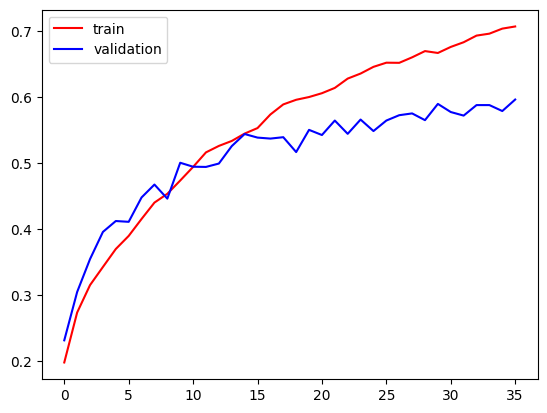

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()
     

In [ ]:
# save the model file to your Google Drive
model_2_with_dropout.save('/content/gdrive/My Drive/model_2_with_dropout.h5')

Its better than before but still overfitting

We can  try to do data augmentation to get better results

## DATA AUGMENTATION

In [ ]:
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(128,128,3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.3),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
])

In [ ]:
model_a = Sequential([data_augmentation,model])


In [ ]:
model_a.compile(loss = 'CategoricalCrossentropy',optimizer='adam', metrics = ['accuracy'])

In [ ]:
early_stop=EarlyStopping(monitor= 'val_loss',patience=5,restore_best_weights=True,mode='min')

In [ ]:
BATCH_SIZE=32
model_a.fit(train_generator,epochs=20,
            steps_per_epoch=train_generator.samples//BATCH_SIZE,
            validation_data=test_generator,
            validation_steps=test_generator.samples//BATCH_SIZE,
            callbacks=early_stop)

Epoch 1/20
308/308 [==============================] - 119s 385ms/step - loss: 1.3870 - accuracy: 0.5124 - val_loss: 1.8555 - val_accuracy: 0.4531
Epoch 2/20
308/308 [==============================] - 112s 364ms/step - loss: 1.3409 - accuracy: 0.5346 - val_loss: 1.7402 - val_accuracy: 0.4823
Epoch 3/20
308/308 [==============================] - 113s 368ms/step - loss: 1.3074 - accuracy: 0.5469 - val_loss: 1.7916 - val_accuracy: 0.4585
Epoch 4/20
308/308 [==============================] - 115s 372ms/step - loss: 1.2906 - accuracy: 0.5450 - val_loss: 1.6836 - val_accuracy: 0.4627
Epoch 5/20
308/308 [==============================] - 135s 437ms/step - loss: 1.2714 - accuracy: 0.5530 - val_loss: 2.2313 - val_accuracy: 0.4252
Epoch 6/20
308/308 [==============================] - 114s 369ms/step - loss: 1.2516 - accuracy: 0.5602 - val_loss: 1.9189 - val_accuracy: 0.4501
Epoch 7/20
308/308 [==============================] - 137s 446ms/step - loss: 1.2209 - accuracy: 0.5746 - val_loss: 1.7084 -

In [ ]:
loss, accuracy = model_a.evaluate(test_generator)
print("Loss:", loss)
print("Accuracy:", accuracy)

105/105 [==============================] - 20s 193ms/step - loss: 1.9141 - accuracy: 0.4721
Loss: 1.9140827655792236
Accuracy: 0.4720645248889923


Our mode is  still performing  poorly especially on test set

## Hyper parameter tuning

We can do hyper parameter tuning using keras tuner

In [ ]:
pip install -U keras-tuner


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
final_data = []
final_labels = []

for i in range(0,len(train_generator)):
    batch = train_generator[i]
    for j in range(len(batch[0])):
        final_data.append(batch[0][j])
        final_labels.append(batch[1][j])

val_data = []
val_labels = []

for i in range(0,len(test_generator)):
    batch = test_generator[i]
    for j in range(len(batch[0])):
        val_data.append(batch[0][j])
        val_labels.append(batch[1][j])
        
final_data = np.array(final_data)
final_labels = np.array(final_labels)
val_data = np.array(val_data)
val_labels = np.array(val_labels)

HYPER PARAMETER TUNING FOR DATA AUGMENTATION

In [ ]:
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = keras.Sequential([data_augmentation])  #adding the data augmentation to the keras sequential
    model.add(keras.layers.AveragePooling2D(4,2))
    
    for i in range(hp.Int("Conv Layers", min_value=0, max_value=3)):
        model.add(keras.layers.Conv2D(hp.Choice(f"layer_{i}_filters", [16,32,64]), 3, activation='relu'))
        model.add(keras.layers.MaxPool2D((3,3)))

    model.add(keras.layers.Conv2D(filters=64,kernel_size = (3,3),strides = 1,padding = 'same',activation = 'relu'))
    model.add(keras.layers.Conv2D(filters = 64,kernel_size=(3,3),activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(hp.Choice("Dense layer", [64, 128, 256]), activation='relu'))

    model.add(keras.layers.Dense(11, activation='softmax'))

    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
)

tuner.search(final_data, final_labels, validation_data=(val_data, val_labels), epochs=80)

Trial 10 Complete [00h 07m 28s]
val_loss: 0.18343493342399597

Best val_loss So Far: 0.17622725665569305
Total elapsed time: 00h 48m 15s


In [ ]:
hp_augm = tuner.get_best_models()[0]

In [ ]:
loss, accuracy = hp_augm.evaluate(test_generator)

print("LOSS", loss)
print("ACCURACY", accuracy)

105/105 [==============================] - 26s 246ms/step - loss: 0.1762 - accuracy: 0.5967
LOSS 0.17622725665569305
ACCURACY 0.5966536998748779


We got a better accuracy on the test test

In [108]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Model

In [122]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input


We can use prebuilt models

# Transfer Learning

VGG16

In [44]:
from tensorflow.keras.applications.vgg16 import VGG16


In [66]:
IMAGE_SIZE = [224, 224]

In [ ]:
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg16.layers:
    layer.trainable = False
x = Flatten()(vgg16.output)    
prediction = Dense(11, activation='softmax')(x)


In [ ]:
# create a model object
model5 = Model(inputs=vgg16.input, outputs=prediction)
model5.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [75]:
r = model5.fit_generator(
  train_generator,
  validation_data=test_generator,
  epochs=15,
  steps_per_epoch=len(train_generator),
  validation_steps=len(test_generator)
)

Epoch 1/15
309/309 [==============================] - 192s 618ms/step - loss: 21.0632 - accuracy: 0.5288 - val_loss: 3.3199 - val_accuracy: 0.3463
Epoch 2/15
309/309 [==============================] - 186s 601ms/step - loss: 21.8572 - accuracy: 0.6150 - val_loss: 4.7691 - val_accuracy: 0.2563
Epoch 3/15
309/309 [==============================] - 187s 605ms/step - loss: 22.7855 - accuracy: 0.6480 - val_loss: 4.5888 - val_accuracy: 0.2611
Epoch 4/15
309/309 [==============================] - 196s 635ms/step - loss: 22.4221 - accuracy: 0.6666 - val_loss: 6.2648 - val_accuracy: 0.2904
Epoch 5/15
309/309 [==============================] - 188s 609ms/step - loss: 24.0020 - accuracy: 0.6826 - val_loss: 6.5225 - val_accuracy: 0.2584
Epoch 6/15
309/309 [==============================] - 185s 600ms/step - loss: 24.5806 - accuracy: 0.6823 - val_loss: 7.9893 - val_accuracy: 0.2504
Epoch 7/15
309/309 [==============================] - 187s 605ms/step - loss: 24.8610 - accuracy: 0.6894 - val_loss: 7

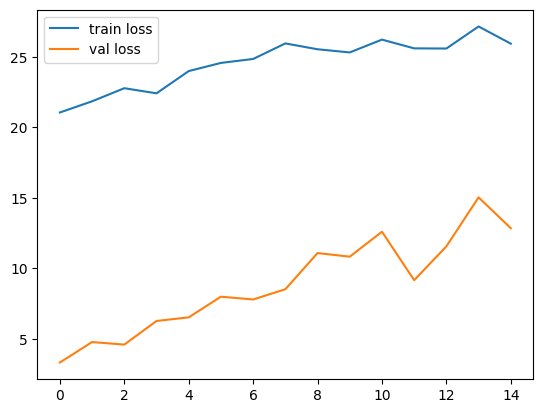

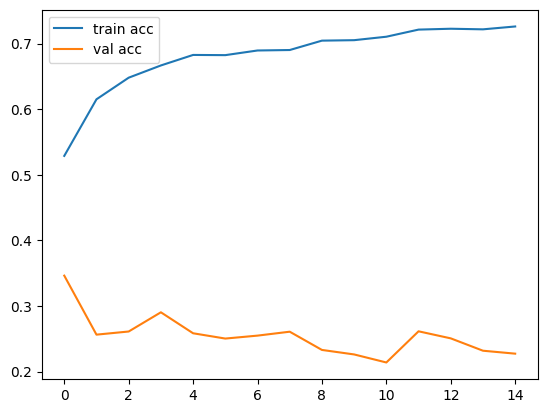

<Figure size 640x480 with 0 Axes>

In [76]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

We got a very bad performance too much overfitting

## InceptionNet

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)

# For test data we only rescale the data.
# Never augment test data!!!
test_datagen = ImageDataGenerator(rescale=1./255)


# Train generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(250, 250),
    batch_size=32,
    classes=CLASSES,
    class_mode='categorical'
)
# Test generator
test_generator = test_datagen.flow_from_directory(
    VAL_DATA_DIR, 
    classes=CLASSES,
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical'
)

Inception Net

In [124]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(11, activation='softmax', kernel_initializer='random_uniform')(x)

model3 = Model(inputs=base_model.input, outputs=predictions)

# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False
    
optimizer = Adam()
model3.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [126]:
epochs = 15

# Saving the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model_incept.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=6,verbose=1)
]
BATCH_SIZE=32
history = model3.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=test_generator,
        verbose = 1,
        validation_steps=test_generator.samples // BATCH_SIZE)

Epoch 1/15
308/308 [==============================] - ETA: 0s - loss: 0.8920 - accuracy: 0.7391
Epoch 1: val_loss improved from inf to 0.60424, saving model to model_incept.h5
308/308 [==============================] - 144s 424ms/step - loss: 0.8920 - accuracy: 0.7391 - val_loss: 0.6042 - val_accuracy: 0.8029
Epoch 2/15
308/308 [==============================] - ETA: 0s - loss: 0.3886 - accuracy: 0.8701
Epoch 2: val_loss did not improve from 0.60424
308/308 [==============================] - 106s 344ms/step - loss: 0.3886 - accuracy: 0.8701 - val_loss: 0.6297 - val_accuracy: 0.8119
Epoch 3/15
308/308 [==============================] - ETA: 0s - loss: 0.2036 - accuracy: 0.9323
Epoch 3: val_loss did not improve from 0.60424
308/308 [==============================] - 119s 385ms/step - loss: 0.2036 - accuracy: 0.9323 - val_loss: 0.6531 - val_accuracy: 0.8278
Epoch 4/15
308/308 [==============================] - ETA: 0s - loss: 0.1182 - accuracy: 0.9625
Epoch 4: val_loss improved from 0.604

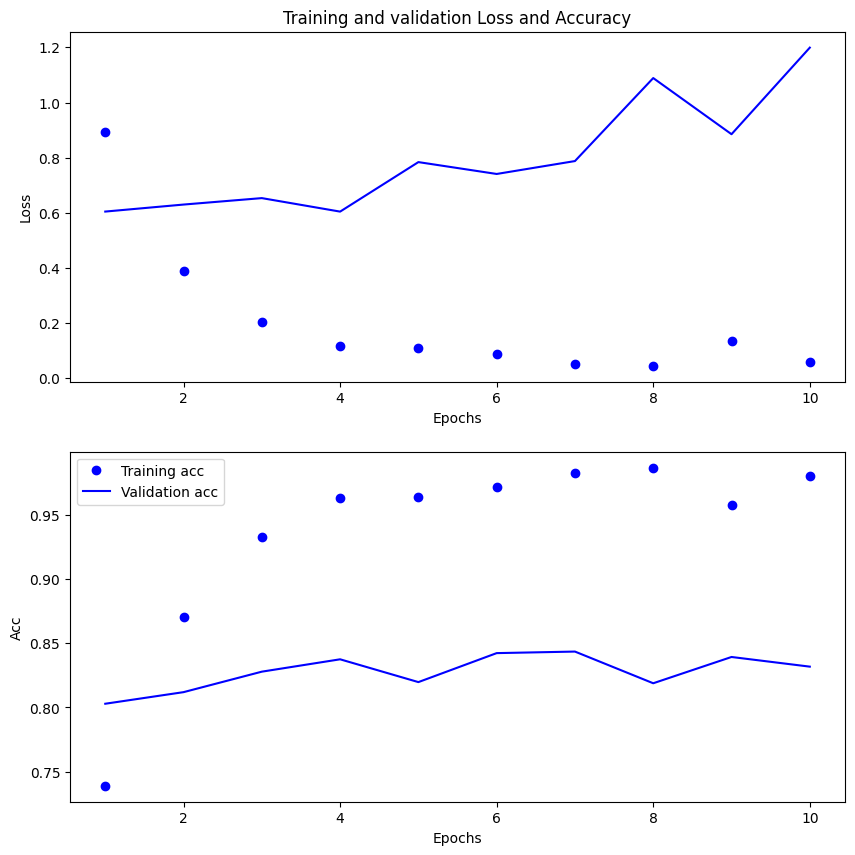

In [128]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

InceptionNet with data augmentation

In [131]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=.05,
    height_shift_range=.05,
    horizontal_flip=True,
    zoom_range=0.3
)

# For test data we only rescale the data.
# Never augment test data!!!
test_datagen = ImageDataGenerator(rescale=1./255)


# Train generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(250, 250),
    batch_size=32,
    classes=CLASSES,
    class_mode='categorical'
)
# Test generator
test_generator = test_datagen.flow_from_directory(
    VAL_DATA_DIR, 
    classes=CLASSES,
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical'
)

Found 9866 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


In [132]:
base_model2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

x = base_model2.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(11, activation='softmax', kernel_initializer='random_uniform')(x)

model4 = Model(inputs=base_model2.input, outputs=predictions)

# Freezing pretrained layers
for layer in base_model2.layers:
    layer.trainable=False
    
optimizer = Adam()
model4.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [133]:
epochs = 15

# Saving the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model_incept2.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=6,verbose=1)
]
BATCH_SIZE=32
history = model4.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=test_generator,
        verbose = 1,
        validation_steps=test_generator.samples // BATCH_SIZE)

Epoch 1/15
308/308 [==============================] - ETA: 0s - loss: 0.9620 - accuracy: 0.7109
Epoch 1: val_loss improved from inf to 0.57211, saving model to model_incept2.h5
308/308 [==============================] - 255s 790ms/step - loss: 0.9620 - accuracy: 0.7109 - val_loss: 0.5721 - val_accuracy: 0.8062
Epoch 2/15
308/308 [==============================] - ETA: 0s - loss: 0.6213 - accuracy: 0.7966
Epoch 2: val_loss did not improve from 0.57211
308/308 [==============================] - 224s 728ms/step - loss: 0.6213 - accuracy: 0.7966 - val_loss: 0.5957 - val_accuracy: 0.7999
Epoch 3/15
308/308 [==============================] - ETA: 0s - loss: 0.5737 - accuracy: 0.8131
Epoch 3: val_loss improved from 0.57211 to 0.55710, saving model to model_incept2.h5
308/308 [==============================] - 237s 771ms/step - loss: 0.5737 - accuracy: 0.8131 - val_loss: 0.5571 - val_accuracy: 0.8272
Epoch 4/15
308/308 [==============================] - ETA: 0s - loss: 0.5198 - accuracy: 0.828

In [143]:
model4.evaluate_generator(
    test_generator, 
    steps = test_generator.n // 32, 
    verbose = 1
)

104/104 [==============================] - 29s 279ms/step - loss: 0.5635 - accuracy: 0.8395


[0.563451886177063, 0.8395432829856873]

Thats the best model we got with a test accuracy of 84%

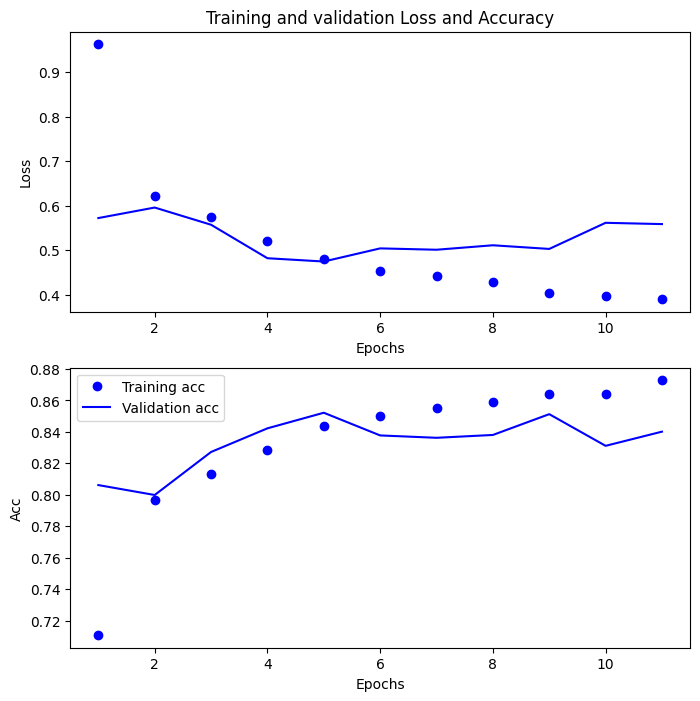

In [135]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [136]:
# Assigning label names to the corresponding indexes
labels = {
    0: 'Bread', 
    1: 'Dairy product', 
    2: 'Dessert', 
    3: 'Egg', 
    4: 'Fried food', 
    5: 'Meat',
    6: 'Noodles-Pasta',
    7: 'Rice', 
    8: 'Seafood',
    9: 'Soup',
    10: 'Vegetable-Fruit'
}

In [137]:
# Loading images and their predictions 
import PIL
prediction = []
original = []
image = []
count = 0
path_eval = "/content/validation"
for i in os.listdir(path_eval):
    for item in os.listdir(os.path.join(path_eval, i)):
        #code to open the image
        img= PIL.Image.open(os.path.join(path_eval, i, item))
        #resizing the image to (256,256)
        img = img.resize((250,250))
        #appending image to the image list
        image.append(img)
        #converting image to array
        img = np.asarray(img, dtype= np.float32)
        #normalizing the image
        img = img / 255
        #reshaping the image in to a 4D array
        img = img.reshape(-1,250,250,3)
        #making prediction of the model
        predict = model.predict(img)
        #getting the index corresponding to the highest value in the prediction
        predict = np.argmax(predict)
        #appending the predicted class to the list
        prediction.append(labels[predict])
        #appending original class to the list
        original.append(i)

1/1 [==============================] - 0s 40ms/step


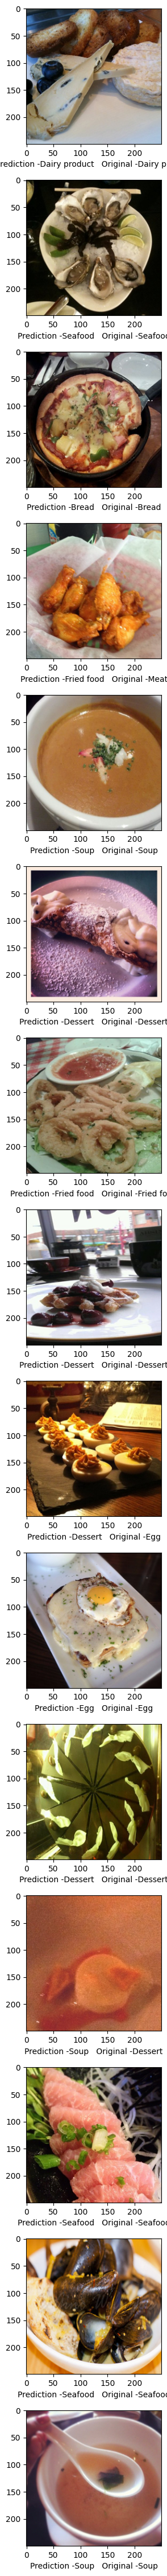

In [142]:
# Visualizing the results
fig=plt.figure(figsize = (60,60))
for i in range(15):
    j = random.randint(0,len(image))
    fig.add_subplot(20,1,i+1)
    plt.xlabel("Prediction -" + prediction[j] +"   Original -" + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()